**Import Library**

In [37]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from keras.layers import Dense, LSTM, Conv1D, Conv2D, Dropout, MaxPooling3D
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

**Import Dataset**

In [38]:
df = pd.read_excel("C:/Users/User/Documents/forecastinglstm.xlsx",
                   header = 0, index_col = 'Date')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70 entries, 2018-01-01 to 2023-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   70 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB


In [39]:
round(df.describe(), 2).T

,count,mean,std,min,25%,50%,75%,max
Price,70.0,12683.89,542.35,12182.61,12353.07,12537.93,12693.57,15008.98


## **Time Series Plot**

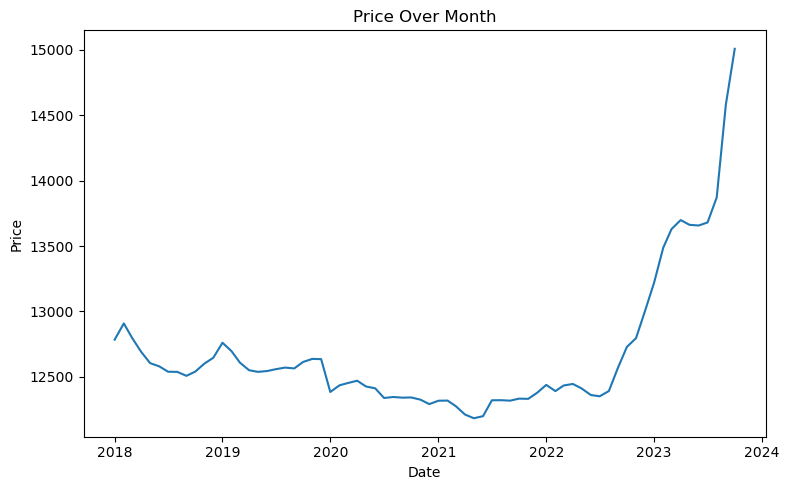

In [40]:
# plot data over month
plt.figure(figsize=(8, 5))
plt.title('Price Over Month')
plt.plot(df['Price'])
plt.xlabel('Date')
plt.ylabel('Price')

plt.tight_layout()
plt.show()

## **LSTM Model**

**Time Series Transformation to Supervised Format**

In [41]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
	
    return agg

# scaling values
values = df.values
scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var1(t)
1,0.212665,0.256662
2,0.256662,0.217574
3,0.217574,0.179462
4,0.179462,0.149164
5,0.149164,0.140465


### **Sample Unit: 70-30**

**Split Values**

In [42]:
# split values
values = reframed.values
X = values[:, :-1]
y = values[:, -1]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

# reshape in 3D [samples, timestamps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(48, 1, 1) (48,) (21, 1, 1) (21,)


**Model Testing**

In [43]:
# define model
def create_model(LSTM_units, dropout_rate):
    model = Sequential()
    model.add(LSTM(LSTM_units, return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                               restore_best_weights=True)

# model testing
results = []
param_grid = {
    'LSTM_units': [128, 256, 512],
    'dropout_rate': [0.1, 0.2],
    'epochs': [50, 100],
    'batch_size': [32, 64]
}

for LSTM_units in param_grid['LSTM_units']:
    for dropout_rate in param_grid['dropout_rate']:
        for epochs in param_grid['epochs']:
            for batch_size in param_grid['batch_size']:
                model = create_model(LSTM_units=LSTM_units, dropout_rate=dropout_rate)
                history = model.fit(train_X, train_y,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    verbose=0,
                                    validation_data=(test_X, test_y),
                                    shuffle=False,
                                    callbacks=[early_stopping])
                mse = history.history['loss'][-1]
                score = -mse

                result = {
                    'MSE': mse,
                    'LSTM_units': LSTM_units,
                    'dropout_rate': dropout_rate,
                    'epochs': epochs,
                    'batch_size': batch_size
                }

                results.append(result)

results_df = pd.DataFrame(results)
print(results_df)

best_params_df = results_df.loc[results_df['MSE'].idxmin()]

print("\nBest parameters found:")
print(best_params_df)

         MSE  LSTM_units  dropout_rate  epochs  batch_size
0   0.012556         128           0.1      50          32
1   0.025090         128           0.1      50          64
2   0.001955         128           0.1     100          32
3   0.010685         128           0.1     100          64
4   0.013178         128           0.2      50          32
5   0.021936         128           0.2      50          64
6   0.002402         128           0.2     100          32
7   0.013345         128           0.2     100          64
8   0.006102         256           0.1      50          32
9   0.018825         256           0.1      50          64
10  0.001769         256           0.1     100          32
11  0.005412         256           0.1     100          64
12  0.007368         256           0.2      50          32
13  0.017027         256           0.2      50          64
14  0.001682         256           0.2     100          32
15  0.006435         256           0.2     100          

**Fixating The Model**

Epoch 1/100
1/1 - 15s - loss: 0.0687 - val_loss: 0.0690 - 15s/epoch - 15s/step
Epoch 2/100
1/1 - 0s - loss: 0.0646 - val_loss: 0.0653 - 308ms/epoch - 308ms/step
Epoch 3/100
1/1 - 0s - loss: 0.0609 - val_loss: 0.0617 - 240ms/epoch - 240ms/step
Epoch 4/100
1/1 - 0s - loss: 0.0573 - val_loss: 0.0583 - 305ms/epoch - 305ms/step
Epoch 5/100
1/1 - 0s - loss: 0.0539 - val_loss: 0.0551 - 234ms/epoch - 234ms/step
Epoch 6/100
1/1 - 0s - loss: 0.0509 - val_loss: 0.0520 - 261ms/epoch - 261ms/step
Epoch 7/100
1/1 - 0s - loss: 0.0479 - val_loss: 0.0492 - 195ms/epoch - 195ms/step
Epoch 8/100
1/1 - 0s - loss: 0.0451 - val_loss: 0.0465 - 183ms/epoch - 183ms/step
Epoch 9/100
1/1 - 0s - loss: 0.0425 - val_loss: 0.0439 - 180ms/epoch - 180ms/step
Epoch 10/100
1/1 - 0s - loss: 0.0400 - val_loss: 0.0416 - 178ms/epoch - 178ms/step
Epoch 11/100
1/1 - 0s - loss: 0.0376 - val_loss: 0.0394 - 193ms/epoch - 193ms/step
Epoch 12/100
1/1 - 0s - loss: 0.0352 - val_loss: 0.0374 - 172ms/epoch - 172ms/step
Epoch 13/100
1/1

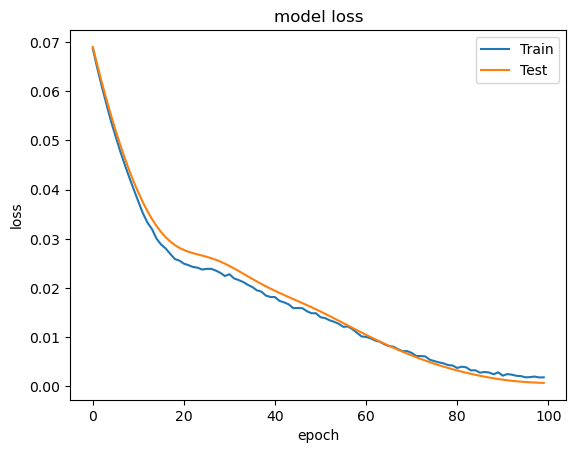

In [44]:
# model
model = Sequential()
model.add(LSTM(512, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                               restore_best_weights=True)

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=64,
                    validation_data=(test_X, test_y), verbose=2,
                    shuffle=False, callbacks=[early_stopping])    

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [45]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape(test_X.shape[0], 1)

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 0:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 0:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# Calculate regression metrics
mse = round(mean_squared_error(inv_y, inv_yhat), 2)
mae = round(mean_absolute_error(inv_y, inv_yhat), 2)
r2 = round(r2_score(inv_y, inv_yhat), 2)

# Convert R-squared to a percentage
r2_percentage = r2 * 100

# Print the metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2_percentage}%')

1/1 [==============================] - 2s 2s/step
Mean Squared Error (MSE): 5767.76
Mean Absolute Error (MAE): 53.49
R-squared (R2): 98.0%


**Accuration Plot**

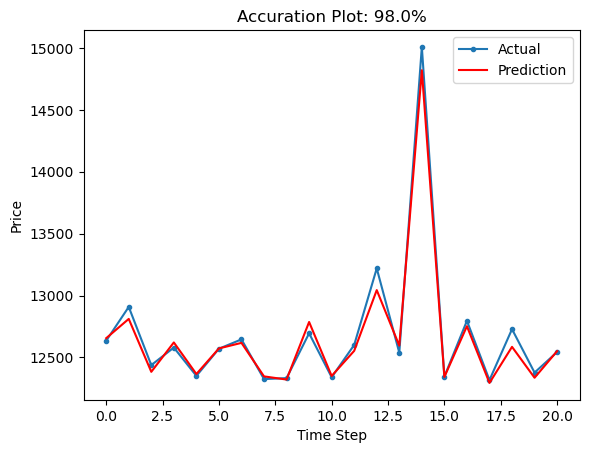

In [46]:
# accuration plot
aa=[x for x in range(len(inv_y))]
plt.plot(aa, inv_y[:len(inv_y)], marker = '.', label = "Actual")
plt.plot(aa, inv_yhat[:len(inv_yhat)], 'r', label = "Prediction")
plt.title(f'Accuration Plot: {round(r2_percentage, 2)}%')
plt.ylabel('Price', size=10)
plt.xlabel('Time Step', size=10)
plt.legend(fontsize=10)
plt.show()

**3 Months Predicted Values**

In [47]:
# dates for predicted values (3 months)
last_date = df.index[-1]
new_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=3, freq='MS')

# Extract the predicted values for the next 3 months
predicted_values_next_3_months = inv_yhat[-3:]

# Create a DataFrame for the predicted values for the next 3 months
predicted_df = pd.DataFrame({'Date': new_dates,
                             'Price': predicted_values_next_3_months})
predicted_df = predicted_df.set_index('Date')

predicted_df

,Price
Date,
2023-11-01,12585.331012
2023-12-01,12335.589898
2024-01-01,12550.828091


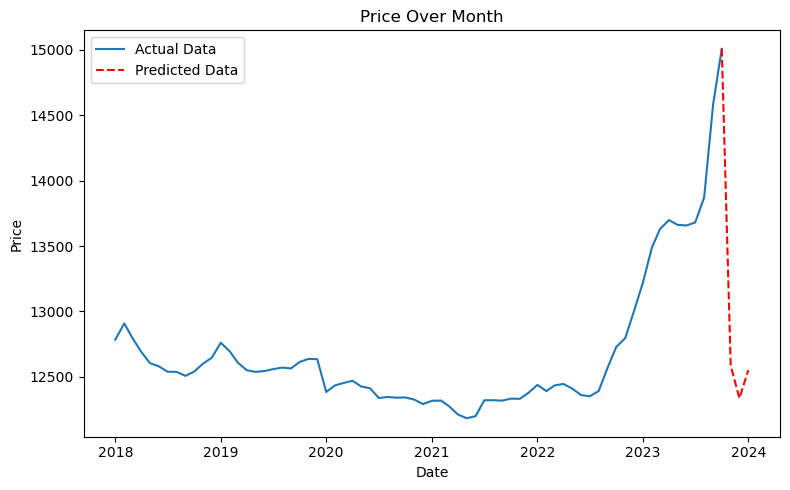

In [48]:
# Create a new DataFrame with the predicted values
new_df = pd.concat([df, predicted_df])
last_3_months = new_df.index[-4:]
last_3_values = new_df.loc[last_3_months]

# Plot data over month
plt.figure(figsize=(8, 5))
plt.title('Price Over Month')
plt.plot(new_df.index[:-3], new_df.loc[new_df.index[:-3]], label='Actual Data')
plt.xlabel('Date')
plt.ylabel('Price')

# Plot the predicted values
plt.plot(last_3_months,
         last_3_values['Price'],
         label='Predicted Data', color='red', linestyle='dashed')

plt.legend()
plt.tight_layout()
plt.show()

### **Sample Unit: 80-20**

**Split Values**

In [21]:
# split values
values = reframed.values
X = values[:, :-1]
y = values[:, -1]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# reshape in 3D [samples, timestamps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(55, 1, 1) (55,) (14, 1, 1) (14,)


**Model Testing**

In [22]:
# define model
def create_model(LSTM_units, dropout_rate):
    model = Sequential()
    model.add(LSTM(LSTM_units, return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                               restore_best_weights=True)

# model testing
results = []
param_grid = {
    'LSTM_units': [128, 256, 512],
    'dropout_rate': [0.1, 0.2],
    'epochs': [50, 100],
    'batch_size': [32, 64]
}

for LSTM_units in param_grid['LSTM_units']:
    for dropout_rate in param_grid['dropout_rate']:
        for epochs in param_grid['epochs']:
            for batch_size in param_grid['batch_size']:
                model = create_model(LSTM_units=LSTM_units, dropout_rate=dropout_rate)
                history = model.fit(train_X, train_y,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    verbose=0,
                                    validation_data=(test_X, test_y),
                                    shuffle=False,
                                    callbacks=[early_stopping])
                mse = history.history['loss'][-1]
                score = -mse

                result = {
                    'MSE': mse,
                    'LSTM_units': LSTM_units,
                    'dropout_rate': dropout_rate,
                    'epochs': epochs,
                    'batch_size': batch_size
                }

                results.append(result)

results_df = pd.DataFrame(results)
print(results_df)

best_params_df = results_df.loc[results_df['MSE'].idxmin()]

print("\nBest parameters found:")
print(best_params_df)

         MSE  LSTM_units  dropout_rate  epochs  batch_size
0   0.029620         128           0.1      50          32
1   0.032232         128           0.1      50          64
2   0.030502         128           0.1     100          32
3   0.034374         128           0.1     100          64
4   0.030897         128           0.2      50          32
5   0.030657         128           0.2      50          64
6   0.030257         128           0.2     100          32
7   0.029252         128           0.2     100          64
8   0.026580         256           0.1      50          32
9   0.028541         256           0.1      50          64
10  0.029135         256           0.1     100          32
11  0.032221         256           0.1     100          64
12  0.026497         256           0.2      50          32
13  0.030502         256           0.2      50          64
14  0.029783         256           0.2     100          32
15  0.031717         256           0.2     100          

**Fixating The Model**

Epoch 1/50
2/2 - 10s - loss: 0.0812 - val_loss: 0.0249 - 10s/epoch - 5s/step
Epoch 2/50
2/2 - 0s - loss: 0.0751 - val_loss: 0.0215 - 165ms/epoch - 83ms/step
Epoch 3/50
2/2 - 0s - loss: 0.0694 - val_loss: 0.0183 - 175ms/epoch - 88ms/step
Epoch 4/50
2/2 - 0s - loss: 0.0641 - val_loss: 0.0156 - 158ms/epoch - 79ms/step
Epoch 5/50
2/2 - 0s - loss: 0.0593 - val_loss: 0.0131 - 150ms/epoch - 75ms/step
Epoch 6/50
2/2 - 0s - loss: 0.0546 - val_loss: 0.0110 - 162ms/epoch - 81ms/step
Epoch 7/50
2/2 - 0s - loss: 0.0512 - val_loss: 0.0093 - 140ms/epoch - 70ms/step
Epoch 8/50
2/2 - 0s - loss: 0.0473 - val_loss: 0.0079 - 154ms/epoch - 77ms/step
Epoch 9/50
2/2 - 0s - loss: 0.0438 - val_loss: 0.0068 - 152ms/epoch - 76ms/step
Epoch 10/50
2/2 - 0s - loss: 0.0407 - val_loss: 0.0061 - 149ms/epoch - 74ms/step
Epoch 11/50
2/2 - 0s - loss: 0.0381 - val_loss: 0.0058 - 150ms/epoch - 75ms/step
Epoch 12/50
2/2 - 0s - loss: 0.0359 - val_loss: 0.0057 - 153ms/epoch - 77ms/step
Epoch 13/50
2/2 - 0s - loss: 0.0345 - va

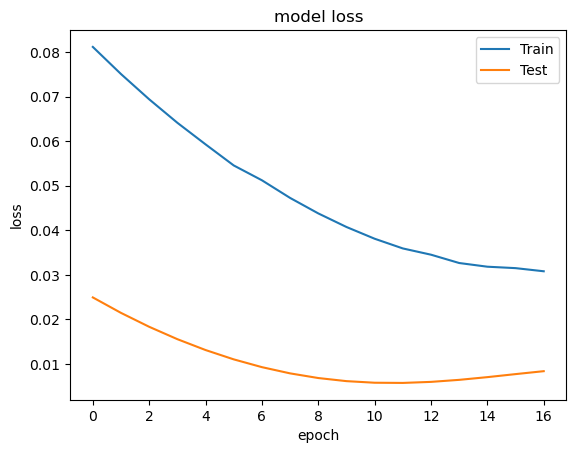

In [23]:
# model
model = Sequential()
model.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                               restore_best_weights=True)

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=32,
                    validation_data=(test_X, test_y), verbose=2,
                    shuffle=False, callbacks=[early_stopping])    

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [24]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape(test_X.shape[0], 1)

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 0:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 0:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# Calculate regression metrics
mse = round(mean_squared_error(inv_y, inv_yhat), 2)
mae = round(mean_absolute_error(inv_y, inv_yhat), 2)
r2 = round(r2_score(inv_y, inv_yhat), 2)

# Convert R-squared to a percentage
r2_percentage = r2 * 100

# Print the metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2_percentage}%')

1/1 [==============================] - 2s 2s/step
Mean Squared Error (MSE): 45794.89
Mean Absolute Error (MAE): 157.02
R-squared (R2): 19.0%


**Accuration Plot**

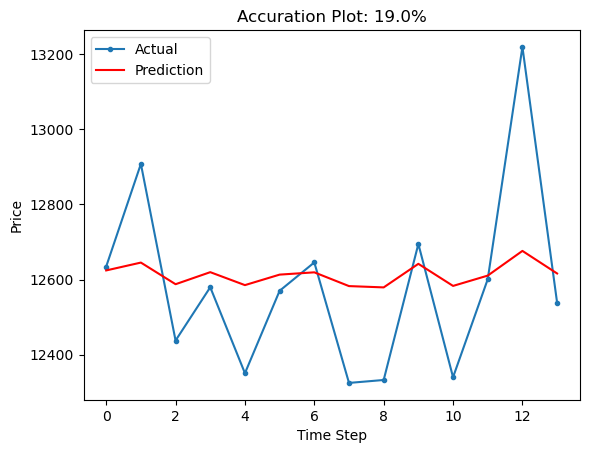

In [25]:
# accuration plot
aa=[x for x in range(len(inv_y))]
plt.plot(aa, inv_y[:len(inv_y)], marker = '.', label = "Actual")
plt.plot(aa, inv_yhat[:len(inv_yhat)], 'r', label = "Prediction")
plt.title(f'Accuration Plot: {round(r2_percentage, 2)}%')
plt.ylabel('Price', size=10)
plt.xlabel('Time Step', size=10)
plt.legend(fontsize=10)
plt.show()

**3 Months Predicted Values**

In [26]:
# dates for predicted values (3 months)
last_date = df.index[-1]
new_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=3, freq='MS')

# Extract the predicted values for the next 3 months
predicted_values_next_3_months = inv_yhat[-3:]

# Create a DataFrame for the predicted values for the next 3 months
predicted_df = pd.DataFrame({'Date': new_dates,
                             'Price': predicted_values_next_3_months})
predicted_df = predicted_df.set_index('Date')

predicted_df

,Price
Date,
2023-11-01,12610.609667
2023-12-01,12676.349560
2024-01-01,12616.266304


In [27]:
# dates for predicted values (3 months)
last_date = df.index[-1]
new_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=3, freq='MS')

# Extract the predicted values for the next 3 months
predicted_values_next_3_months = inv_yhat[-3:]

# Create a DataFrame for the predicted values for the next 3 months
predicted_df = pd.DataFrame({'Date': new_dates,
                             'Price': predicted_values_next_3_months})
predicted_df = predicted_df.set_index('Date')

predicted_df

,Price
Date,
2023-11-01,12610.609667
2023-12-01,12676.349560
2024-01-01,12616.266304


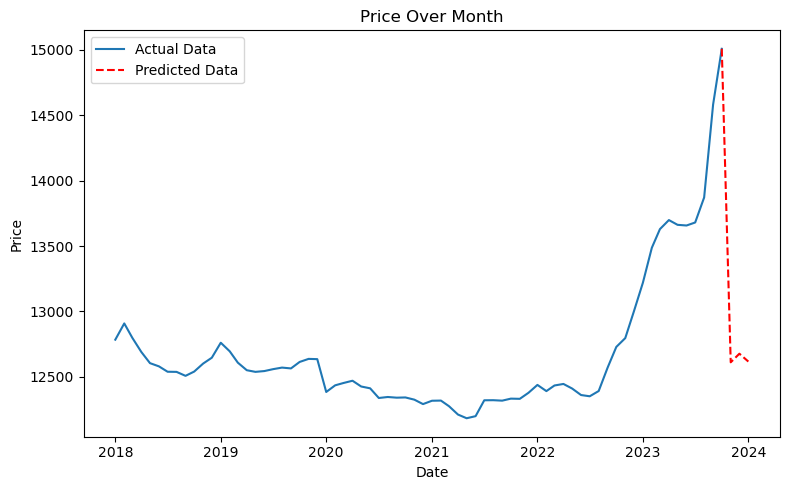

In [28]:
# Create a new DataFrame with the predicted values
new_df = pd.concat([df, predicted_df])
last_3_months = new_df.index[-4:]
last_3_values = new_df.loc[last_3_months]

# Plot data over month
plt.figure(figsize=(8, 5))
plt.title('Price Over Month')
plt.plot(new_df.index[:-3], new_df.loc[new_df.index[:-3]], label='Actual Data')
plt.xlabel('Date')
plt.ylabel('Price')

# Plot the predicted values
plt.plot(last_3_months,
         last_3_values['Price'],
         label='Predicted Data', color='red', linestyle='dashed')

plt.legend()
plt.tight_layout()
plt.show()

### **Sample Unit: 90-10**

**Split Values**

In [29]:
# split values
values = reframed.values
X = values[:, :-1]
y = values[:, -1]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=42)

# reshape in 3D [samples, timestamps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(62, 1, 1) (62,) (7, 1, 1) (7,)


**Model Testing**

In [30]:
# define model
def create_model(LSTM_units, dropout_rate):
    model = Sequential()
    model.add(LSTM(LSTM_units, return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                               restore_best_weights=True)

# model testing
results = []
param_grid = {
    'LSTM_units': [128, 256, 512],
    'dropout_rate': [0.1, 0.2],
    'epochs': [50, 100],
    'batch_size': [32, 64]
}

for LSTM_units in param_grid['LSTM_units']:
    for dropout_rate in param_grid['dropout_rate']:
        for epochs in param_grid['epochs']:
            for batch_size in param_grid['batch_size']:
                model = create_model(LSTM_units=LSTM_units, dropout_rate=dropout_rate)
                history = model.fit(train_X, train_y,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    verbose=0,
                                    validation_data=(test_X, test_y),
                                    shuffle=False,
                                    callbacks=[early_stopping])
                mse = history.history['loss'][-1]
                score = -mse

                result = {
                    'MSE': mse,
                    'LSTM_units': LSTM_units,
                    'dropout_rate': dropout_rate,
                    'epochs': epochs,
                    'batch_size': batch_size
                }

                results.append(result)

results_df = pd.DataFrame(results)
print(results_df)

best_params_df = results_df.loc[results_df['MSE'].idxmin()]

print("\nBest parameters found:")
print(best_params_df)

         MSE  LSTM_units  dropout_rate  epochs  batch_size
0   0.028952         128           0.1      50          32
1   0.030062         128           0.1      50          64
2   0.028572         128           0.1     100          32
3   0.029198         128           0.1     100          64
4   0.028540         128           0.2      50          32
5   0.028974         128           0.2      50          64
6   0.028054         128           0.2     100          32
7   0.029265         128           0.2     100          64
8   0.025405         256           0.1      50          32
9   0.028190         256           0.1      50          64
10  0.026302         256           0.1     100          32
11  0.029104         256           0.1     100          64
12  0.027227         256           0.2      50          32
13  0.027614         256           0.2      50          64
14  0.026942         256           0.2     100          32
15  0.027728         256           0.2     100          

**Fixating The Model**

Epoch 1/50
2/2 - 8s - loss: 0.0710 - val_loss: 0.0190 - 8s/epoch - 4s/step
Epoch 2/50
2/2 - 0s - loss: 0.0628 - val_loss: 0.0146 - 257ms/epoch - 129ms/step
Epoch 3/50
2/2 - 0s - loss: 0.0558 - val_loss: 0.0109 - 261ms/epoch - 130ms/step
Epoch 4/50
2/2 - 0s - loss: 0.0499 - val_loss: 0.0078 - 346ms/epoch - 173ms/step
Epoch 5/50
2/2 - 0s - loss: 0.0446 - val_loss: 0.0055 - 318ms/epoch - 159ms/step
Epoch 6/50
2/2 - 0s - loss: 0.0393 - val_loss: 0.0038 - 235ms/epoch - 117ms/step
Epoch 7/50
2/2 - 0s - loss: 0.0358 - val_loss: 0.0028 - 207ms/epoch - 104ms/step
Epoch 8/50
2/2 - 0s - loss: 0.0326 - val_loss: 0.0025 - 205ms/epoch - 102ms/step
Epoch 9/50
2/2 - 0s - loss: 0.0302 - val_loss: 0.0028 - 202ms/epoch - 101ms/step
Epoch 10/50
2/2 - 0s - loss: 0.0285 - val_loss: 0.0035 - 201ms/epoch - 101ms/step
Epoch 11/50
2/2 - 0s - loss: 0.0275 - val_loss: 0.0045 - 212ms/epoch - 106ms/step
Epoch 12/50
2/2 - 0s - loss: 0.0275 - val_loss: 0.0055 - 195ms/epoch - 98ms/step
Epoch 13/50
2/2 - 0s - loss: 0.0

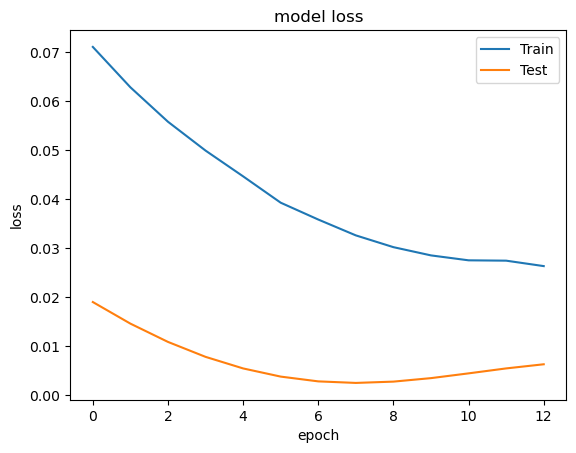

In [32]:
# model
model = Sequential()
model.add(LSTM(512, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                               restore_best_weights=True)

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=32,
                    validation_data=(test_X, test_y), verbose=2,
                    shuffle=False, callbacks=[early_stopping])    

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [33]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape(test_X.shape[0], 1)

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 0:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 0:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# Calculate regression metrics
mse = round(mean_squared_error(inv_y, inv_yhat), 2)
mae = round(mean_absolute_error(inv_y, inv_yhat), 2)
r2 = round(r2_score(inv_y, inv_yhat), 2)

# Convert R-squared to a percentage
r2_percentage = r2 * 100

# Print the metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2_percentage}%')

1/1 [==============================] - 1s 1s/step
Mean Squared Error (MSE): 20245.47
Mean Absolute Error (MAE): 105.23
R-squared (R2): 24.0%


**Accuration Plot**

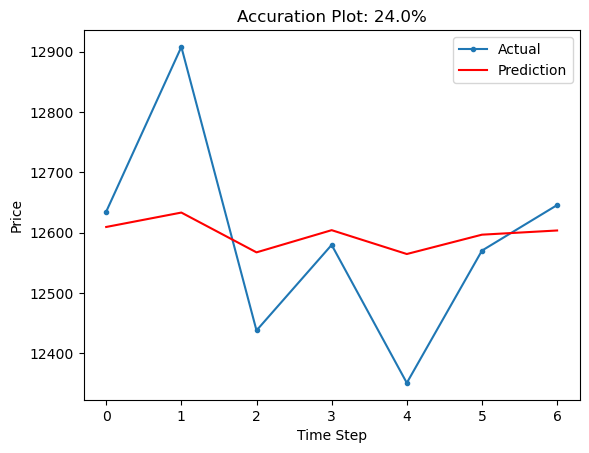

In [34]:
# accuration plot
aa=[x for x in range(len(inv_y))]
plt.plot(aa, inv_y[:len(inv_y)], marker = '.', label = "Actual")
plt.plot(aa, inv_yhat[:len(inv_yhat)], 'r', label = "Prediction")
plt.title(f'Accuration Plot: {round(r2_percentage, 2)}%')
plt.ylabel('Price', size=10)
plt.xlabel('Time Step', size=10)
plt.legend(fontsize=10)
plt.show()

**3 Months Predicted Values**

In [35]:
# dates for predicted values (3 months)
last_date = df.index[-1]
new_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=3, freq='MS')

# Extract the predicted values for the next 3 months
predicted_values_next_3_months = inv_yhat[-3:]

# Create a DataFrame for the predicted values for the next 3 months
predicted_df = pd.DataFrame({'Date': new_dates,
                             'Price': predicted_values_next_3_months})
predicted_df = predicted_df.set_index('Date')

predicted_df

,Price
Date,
2023-11-01,12564.497182
2023-12-01,12596.587598
2024-01-01,12603.538133


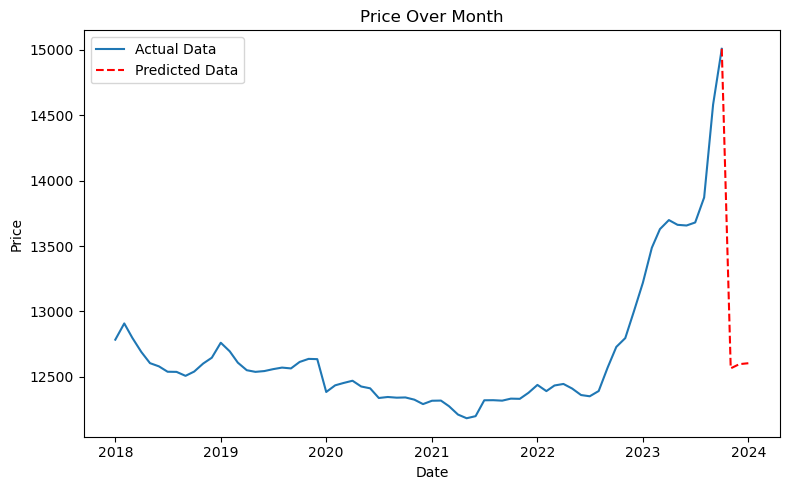

In [36]:
# Create a new DataFrame with the predicted values
new_df = pd.concat([df, predicted_df])
last_3_months = new_df.index[-4:]
last_3_values = new_df.loc[last_3_months]

# Plot data over month
plt.figure(figsize=(8, 5))
plt.title('Price Over Month')
plt.plot(new_df.index[:-3], new_df.loc[new_df.index[:-3]], label='Actual Data')
plt.xlabel('Date')
plt.ylabel('Price')

# Plot the predicted values
plt.plot(last_3_months,
         last_3_values['Price'],
         label='Predicted Data', color='red', linestyle='dashed')

plt.legend()
plt.tight_layout()
plt.show()